In [1]:
from tokenizers import Tokenizer
import transformers
from bart_spektro.modeling_bart_spektro import BartSpektroForConditionalGeneration
from bart_spektro.configuration_bart_spektro import BartSpektroConfig
from data_utils import SpectroDataCollator, SpectroDataset
import torch
from metrics import compute_cos_simils, SpectroMetrics
from train_bart import build_tokenizer
from pathlib import Path
from tqdm import tqdm

# autoreload
%load_ext autoreload
%autoreload 2

[2023-11-28 01:15:44,871] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
tokenizer_path = "tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model"
bpe_tokenizer = Tokenizer.from_file(tokenizer_path)
tokenizer = build_tokenizer(tokenizer_path)

In [149]:
type(tokenizer)

transformers.tokenization_utils_fast.PreTrainedTokenizerFast

In [30]:
tokenizer.special_tokens_map

{'bos_token': '<bos>',
 'eos_token': '<eos>',
 'unk_token': '<ukn>',
 'pad_token': '<pad>'}

In [156]:
a = tokenizer.convert_tokens_to_ids("<bos>")
print(a)

3


In [139]:
pred_smiles = "<bos><nist> Clc1ccc(c(c1)Cl)c1ccc(cc1)OC(=O)c1sccc1S(=O)(=O)N(C)C<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"
gt_smiles = "<nist> Cc1cc2c(c(=S)[nH]1)C(=O)OC2=Cc1ccc(Cl)c(Cl)c1<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>"

pred_ids = tokenizer.encode(pred_smiles)
gt_ids = tokenizer.encode(gt_smiles)
pred_smiles, gt_smiles = tokenizer.decode(pred_ids, skip_special_tokens=True), tokenizer.decode(gt_ids, skip_special_tokens=True)
pred_smiles, gt_smiles


# pred_ids = torch.tensor(pred_ids).unsqueeze(0)
# gt_ids = torch.tensor(gt_ids).unsqueeze(0)

# pred_ids, gt_ids

(' Clc1ccc(c(c1)Cl)c1ccc(cc1)OC(=O)c1sccc1S(=O)(=O)N(C)C',
 ' Cc1cc2c(c(=S)[nH]1)C(=O)OC2=Cc1ccc(Cl)c(Cl)c1')

In [134]:
label_ids = [' CC1CCN(CC1N)Cc1ccns1)CC(C)C']
pred_ids = [' CC1CCN(CC1N)Cc1ccns1)CC(C)C']

In [135]:
metric = SpectroMetrics(tokenizer)
prediction = transformers.EvalPrediction(predictions=pred_ids, label_ids=gt_ids)
compute_cos_simils(label_ids, pred_ids)
# metric(prediction, )

[22:20:13] SMILES Parse Error: extra close parentheses while parsing: CC1CCN(CC1N)Cc1ccns1)CC(C)C
[22:20:13] SMILES Parse Error: Failed parsing SMILES ' CC1CCN(CC1N)Cc1ccns1)CC(C)C' for input: ' CC1CCN(CC1N)Cc1ccns1)CC(C)C'
[22:20:13] SMILES Parse Error: extra close parentheses while parsing: CC1CCN(CC1N)Cc1ccns1)CC(C)C
[22:20:13] SMILES Parse Error: Failed parsing SMILES ' CC1CCN(CC1N)Cc1ccns1)CC(C)C' for input: ' CC1CCN(CC1N)Cc1ccns1)CC(C)C'
ic| pred: ' CC1CCN(CC1N)Cc1ccns1)CC(C)C'
    true: ' CC1CCN(CC1N)Cc1ccns1)CC(C)C'


[0.0]

In [147]:

simil1 = " Clc1ccc(c(c1)Cl)c1ccc(cc1)OC(=O)c1sccc1S(=O)(=O)N(C)C"
simil2 = "Cc1cc2c(c(=S)[nH]1)C(=O)OC2=Cc1ccc(Cl)c(Cl)c1"
a,b,c = compute_cos_simils([simil1], [simil2], tokenizer)
display(b[0])
display(c[0])

[22:29:48] SMILES Parse Error: syntax error while parsing: <neims>
[22:29:48] SMILES Parse Error: Failed parsing SMILES '<neims>' for input: '<neims>'
ic| pred: ' Clc1ccc(c(c1)Cl)c1ccc(cc1)OC(=O)c1sccc1S(=O)(=O)N(C)C'
    true: '<neims> Cc1cc2c(c(=S)[nH]1)C(=O)OC2=Cc1ccc(Cl)c(Cl)c1'


None

None

In [35]:
config = BartSpektroConfig(True, vocab_size=len(tokenizer.get_vocab()), max_log_id=9)
model = BartSpektroForConditionalGeneration(config)
# model = BartSpektroForConditionalGeneration.from_pretrained("checkpoints/bart_2023-04-07-18_27_23_30Mneims/checkpoint-1670000/")
None

In [33]:
model.model.encoder.embed_tokens.weight.shape, model.model.decoder.embed_tokens.weight.shape

(torch.Size([1240, 1024]), torch.Size([1240, 1024]))

In [8]:
dataset = SpectroDataset("data/datasets/DEBUG/DEBUG_valid.jsonl")
loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=SpectroDataCollator())

In [12]:
for batch in loader:
    preds = model.generate(input_ids=batch["input_ids"],
                           position_ids=batch["position_ids"],
                           attention_mask=batch["attention_mask"],
                           max_length=100,
                           num_gen)
    break

In [18]:
tokenizer.decode_batch(preds.tolist(), skip_special_tokens=False)

['<pad>NCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCCOCOCCOCCOCOCCOCCOCOCCOCCOCOCCOCCOCOCCOCCOCOCCOCCOCOCCOCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCC<pad>',
 '<pad>FCCOCCNC23232323232323232323\x1aFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOC

In [29]:
list(filter(lambda x: x.startswith("<"), list(tokenizer.get_vocab().keys())))

['<bos>',
 '<eos>',
 '<source3>',
 '<pad>',
 '<trafo>',
 '<nist>',
 '<ukn>',
 '<source2>',
 '<',
 '<rassp>',
 '<source1>',
 '<neims>']

In [25]:
tokenizer.add_special_tokens(["<trafo>"])

1

In [27]:
tokenizer.save("tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model")

In [42]:
from torchdata.datapipes.iter import IterableWrapper, FileOpener, JsonParser
from data_utils import build_single_datapipe
pipe = build_single_datapipe("data/datasets/DEBUG_dummy/1.jsonl", shuffle=False)
loader = torch.utils.data.DataLoader(pipe, batch_size=2, collate_fn=SpectroDataCollator())
len(loader)

In [39]:
dp = IterableWrapper(range(10))
list(dp)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [54]:
list(datapipe2)

[('data/datasets/DEBUG/DEBUG_train.jsonl',
  StreamWrapper<<_io.BufferedReader name='data/datasets/DEBUG/DEBUG_train.jsonl'>>),
 ('data/datasets/DEBUG/DEBUG_valid.jsonl',
  StreamWrapper<<_io.BufferedReader name='data/datasets/DEBUG/DEBUG_valid.jsonl'>>)]

### DATAPIPES DEMO

In [2]:
import csv
import random

def generate_csv(file_label, num_rows: int = 5000, num_features: int = 20) -> None:
    fieldnames = ['label'] + [f'c{i}' for i in range(num_features)]
    writer = csv.DictWriter(open(f"sample_data{file_label}.csv", "w", newline=''), fieldnames=fieldnames)
    writer.writeheader()
    for i in range(num_rows):
        row_data = {col: random.random() for col in fieldnames}
        row_data['label'] = random.randint(0, 9)
        writer.writerow(row_data)

In [3]:
import numpy as np
import torchdata.datapipes as dp

def filter_for_data(filename):
    return "sample_data" in filename and filename.endswith(".csv")

def row_processor(row):
    return {"label": np.array(row[0], np.int32), "data": np.array(row[1:], dtype=np.float64)}

def build_datapipes(root_dir="."):
    datapipe = dp.iter.FileLister(root_dir)
    datapipe = datapipe.filter(filter_fn=filter_for_data)
    datapipe = datapipe.open_files(mode='rt')
    datapipe = datapipe.parse_csv(delimiter=",", skip_lines=1)
    # Shuffle will happen as long as you do NOT set `shuffle=False` later in the DataLoader
    datapipe = datapipe.shuffle()
    datapipe = datapipe.sharding_filter()  # !!! AFTER SHUFFLE, BEFORE EXPENSIVE OPERATIONS !!!
    datapipe = datapipe.map(row_processor)
    return datapipe

In [4]:
from torch.utils.data_utils import DataLoader

if __name__ == '__main__':
    num_files_to_generate = 3
    for i in range(num_files_to_generate):
        generate_csv(file_label=i, num_rows=10, num_features=3)
    datapipe = build_datapipes()
    dl = DataLoader(dataset=datapipe, batch_size=5, num_workers=2)
    first = next(iter(dl))
    labels, features = first['label'], first['data']
    print(f"Labels batch shape: {labels.size()}")
    print(f"Feature batch shape: {features.size()}")
    print(f"{labels = }\n{features = }")
    n_sample = 0
    for query_row in iter(dl):
        n_sample += 1
    print(f"{n_sample = }")

Labels batch shape: torch.Size([5])
Feature batch shape: torch.Size([5, 3])
labels = tensor([2, 3, 9, 7, 8], dtype=torch.int32)
features = tensor([[0.4408, 0.9905, 0.0471],
        [0.5507, 0.3512, 0.5192],
        [0.9291, 0.2817, 0.8013],
        [0.2765, 0.6562, 0.9340],
        [0.6604, 0.9201, 0.0606]], dtype=torch.float64)
n_sample = 6


### My DATAPIPELINE

In [2]:
import json
import torch
from typing import List, Dict
from torch.utils.data_utils importimportimportimportimportimportimport DataLoader
from data_utils import SpectroDataCollator, SpectroDataset, load_all_datapipes
import yaml

# autoreload
%load_ext autoreload
%autoreload 2

In [7]:
# TRY IT OUT
with open("configs/train_config.yaml", "r") as f:
    try:
        config = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        raise ValueError("Error in configuration file:", exc) from exc

collate_fn = SpectroDataCollator()
datapipes = load_all_datapipes(config["data_args"])
datapipes

# dl = DataLoader(dataset=datapipe, batch_size=1, num_workers=1, collate_fn=collate_fn)
# first = next(iter(dl))
# n_sample = 0
# for row in iter(dl):
#     print(row)
#     n_sample += 1
#     if n_sample == 20:
#         break
# print(f"{n_sample = }")

100
100
10
10
1
1


{'train': SampleMultiplexerDataPipe,
 'valid': {'debug1': MapperIterDataPipe, 'debug2': MapperIterDataPipe},
 'example': {'debug1': MapperIterDataPipe, 'debug2': MapperIterDataPipe}}

In [11]:
len(list(iter(datapipes["example"]["debug2"])))

('data/datasets/DEBUG/DEBUG_valid.jsonl', '{"smiles":"CCNC(c1cnn2c1OCCC2)CC=C=C","input_ids":[26,27,28,30,38,39,40,41,42,43,44,45,46,50,51,52,53,54,55,56,58,59,60,63,64,65,66,67,68,69,70,72,75,77,78,79,80,81,82,83,87,89,90,91,92,93,94,95,104,105,106,107,108,109,110,116,117,118,119,120,121,122,129,131,132,133,136,145,146,147,148,149,150,159,160,161,162,163,164,165,166,173,174,175,176,177,188,189,190,200,204,205,206,218,219,232,233,234,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2],"labels":[1233,224,283,11,70,20,284,21,70,20,378,21,12,261,32,38,32,38,0,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100

1

In [19]:
import torchdata.datapipes as dp
from torch.utils.data_utils import SequentialSampler

pipe = dp.iter.Sampler(datapipe)
# len(list(iter(pipe)))

NameError: name 'datapipe' is not defined

In [80]:
from data_utils import load_all_datapipes

In [95]:
data_args ={
    "buffer_size": 1000, # for shuffling in dataloader
    "datasets": 
        {"30M_rassp": 
            {"train_path": "data/datasets/30M_rassp/30M_rassp_train.jsonl",
            "valid_path": "data/datasets/30M_rassp/30M_rassp_valid.jsonl",
            "weight": 1.0,
            "limit_val_split": 1000,
            "limit_example_split": 100},
        "nist":
            {"train_path": "data/datasets/NIST/NIST_split_filip/train.jsonl",
            "valid_path": "data/datasets/NIST/NIST_split_filip/valid.jsonl",
            "weight": 1.0,
            "limit_val_split": 1000,
            "limit_example_split": 100}
        }
}

datapipes = load_all_datapipes(data_args)

In [99]:
dl = DataLoader(dataset=datapipes["valid"]["30M_rassp"], batch_size=8, num_workers=1, collate_fn=collate_fn)
first = next(iter(dl))
n_sample = 0
for query_row in iter(dl):
    print(query_row)
    n_sample += 1
    if n_sample == 20:
        break
print(f"{n_sample = }")

{'input_ids': tensor([[17, 18, 26,  ...,  2,  2,  2],
        [30, 33, 34,  ...,  2,  2,  2],
        [28, 33, 34,  ...,  2,  2,  2],
        ...,
        [25, 26, 27,  ...,  2,  2,  2],
        [37, 38, 39,  ...,  2,  2,  2],
        [27, 28, 29,  ...,  2,  2,  2]]), 'position_ids': tensor([[ 3,  4,  4,  ..., -1, -1, -1],
        [ 4,  2,  2,  ..., -1, -1, -1],
        [ 2,  2,  3,  ..., -1, -1, -1],
        ...,
        [ 0,  2,  6,  ..., -1, -1, -1],
        [ 0,  5,  8,  ..., -1, -1, -1],
        [ 0,  0,  3,  ..., -1, -1, -1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'decoder_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1,

In [1]:
datapipes

NameError: name 'datapipes' is not defined

In [13]:
tokenizer.pad_token_id

NameError: name 'tokenizer' is not defined

In [7]:
a = range(10)[None:4]
a

range(0, 4)

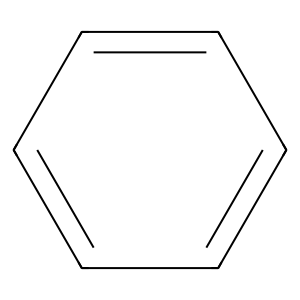

In [19]:
from rdkit import Chem
Chem.Draw.MolToImage(Chem.MolFromSmiles("C1=CC=CC=C1"))

In [21]:
# what is the path of python behind this notebook
import sys
sys.executable

'/home/xhajek9/miniconda3/envs/BARTtrain/bin/python'

In [25]:
import rdkit.Chem.Draw


In [27]:
from rdkit.Chem import Draw, MolFromSmiles

### Callback debug

In [30]:
from __future__ import annotations

import math
import pathlib
import shutil
from typing import Callable, Iterable

from tqdm.auto import tqdm
import pandas as pd
import transformers
import tokenizers
import wandb
import torch
import torch.utils.data
import warnings
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, MolFromSmiles, RDKFingerprint

In [34]:
pred_mol = Chem.MolFromSmiles("C1=CC=CC=C1")
type(pred_mol)

rdkit.Chem.rdchem.Mol

In [38]:
from callbacks import PredictionLogger # compute_cos_simils

ImportError: attempted relative import with no known parent package

In [45]:
a = {"a":2, "b":3}
x = a.get("c", None) 

In [46]:
x is None

True

In [149]:
transformers.Trainer()

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


RuntimeError: `Trainer` requires either a `model` or `model_init` argument

In [125]:
from spectra_process_utils import msp_file_to_jsonl

msp_file_to_jsonl("data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-35_10.msp", 
                  "tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model",
                  source_token="<rassp>",
                  path_jsonl="data/datasets/30M_rassp/rassp_gen/TEST.jsonl", 
                  max_cumsum=0.995)

100%|██████████| 1000/1000 [00:00<00:00, 1197.74it/s]


0 no smiles
0 smiles too long
0 spectra corrupted
0 spectra w/ too high mz
13 spectra w/ too many peaks
totally 13 issues
discarded 13/1000 spectra 


In [123]:
from pathlib import Path
 
num_processes = 32
dir = "data/datasets/30M_rassp/rassp_gen/msps/"
files = list(Path(dir).glob("*"))
pad_len = num_processes - (len(files)%num_processes)
files += [None] * pad_len
grouped_files = np.array(files).reshape(32, -1)
# indexes = np.arange(len(files)).reshape(10, -1)
grouped_files

array([[PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-17_67.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-36_43.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-47_90.msp'),
        ...,
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-28_53.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-21_17.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-18_23.msp')],
       [PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-06_54.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-15_11.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-26_82.msp'),
        ...,
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-16_89.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-43_49.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-44_73.msp')],


In [131]:
# split rassp dataset to train test valid
def data_split(df, train_test_valid_ratio: list):
    """split the df into train, test and valid sets"""
    if sum(train_test_valid_ratio) != 1:
        print("train_test_valid_ratio does not sum to 1")
        return None, None, None
    train_set = df.sample(
        frac=train_test_valid_ratio[0], random_state=42)
    rest = df.drop(train_set.index)

    test_set = rest.sample(frac=train_test_valid_ratio[1]/(train_test_valid_ratio[1]+train_test_valid_ratio[2]),
                           random_state=42)
    valid_set = rest.drop(test_set.index)
    print(f"train len: {len(train_set)}, test len: {len(test_set)}, valid len: {len(valid_set)}")
    return train_set, test_set, valid_set

In [127]:
df = pd.read_json("data/datasets/30M_rassp/rassp_gen/jsonls/all.jsonl", lines=True)

In [132]:
train, test, valid = data_split(df, [0.9, 0.05, 0.05])

train len: 4322581, test len: 240144, valid len: 240143


In [134]:
train.to_json("data/datasets/30M_rassp/rassp_gen/train.jsonl", orient="records", lines=True)
test.to_json("data/datasets/30M_rassp/rassp_gen/test.jsonl", orient="records", lines=True)
valid.to_json("data/datasets/30M_rassp/rassp_gen/valid.jsonl", orient="records", lines=True)

## NIST preprocess again (no overlaps in train - valid now)

In [21]:
from spectra_process_utils import msp_file_to_jsonl
from pathlib import Path

for dataset_type in ["train"]:
    dataset_path = Path("data/datasets/NIST/NIST_split_filip_canon_destereo")
    source_token = "<nist>"
    msp_file_to_jsonl(dataset_path / f"{dataset_type}.msp",
                    tokenizer_path,
                    source_token,
                    path_jsonl=dataset_path / f"{dataset_type}.jsonl",
                    keep_spectra=True
                    )

100%|██████████| 232025/232025 [02:09<00:00, 1784.95it/s]


0 no smiles
363 smiles too long
0 spectra corrupted
5873 spectra w/ too high mz
19894 spectra w/ too many peaks
totally 26130 issues
discarded 23577/232025 spectra 


OSError: Cannot save file into a non-existent directory: 'data/datasets/NIST/NIST_split_filip_canon_destereo'

In [3]:
pd.read_json("data/datasets/NIST/NIST_split_filip_canon_destereo/valid.jsonl", lines=True)

ValueError: Expected object or value

## Rename a wandb group

In [3]:
import wandb
api = wandb.Api()
for r in api.runs("hajekad/BART_for_gcms", filters={"display_name": "earnest-terrain-290_from_scratch_shuffle"}):
    r.group = "finetune_no_shuffle_no_destereo"
    r.update()

## De novo evaluation
moved to a script "data/precompute_denovo_index.py"

In [1]:
# read jsonl file
import json
import pandas as pd
import numpy as np
from matchms.similarity import CosineGreedy
from matchms import Spectrum
from tqdm import tqdm
from rdkit import Chem, DataStructs
import multiprocessing
from pathlib import Path


In [3]:
df_train = pd.read_json("data/datasets/NIST/NIST_split_filip/train.jsonl", lines=True, orient="records")
df_valid = pd.read_json("data/datasets/NIST/NIST_split_filip/valid.jsonl", lines=True, orient="records")

In [183]:
def find_best_indexes_and_similarities(df_query, ref_spectra, ref_fps, outfile_path, process_id=None):
    """find the best match for the given row and write them line by line to a file"""
    if process_id is not None:
        print(f"process {process_id} started")

    print("APPENDING TO THE OLD OUTFILE - IS THAT OK?")
    outfile = open(outfile_path, "a+")

    cosine_greedy = CosineGreedy()
    best_spec_simils = []
    best_smiles_simils = []
    best_indexes = []
    for _, query_row in tqdm(df_query.iterrows(), desc="outer loop"):
        query_spec = Spectrum(mz=np.array(query_row.mz),
                        intensities=np.array(query_row.intensity),
                        metadata_harmonization=False)
        query_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(query_row.smiles))
        best_spec_simil = 0
        best_index = 0
        for index, ref_spec in enumerate(ref_spectra):
            spec_score = float(cosine_greedy.pair(query_spec, ref_spec)["score"])
            if spec_score > best_spec_simil:
                best_spec_simil = spec_score
                best_index = index
        smiles_score = DataStructs.FingerprintSimilarity(query_fp, ref_fps[best_index])
        
        best_spec_simils.append(best_spec_simil)
        best_indexes.append(best_index)  
        best_smiles_simils.append(smiles_score)
        
        # update row and write itto file
        query_row["index_of_closest"] = best_index
        query_row["spectra_sim_of_closest"] = best_spec_simil
        query_row["smiles_sim_of_closest"] = smiles_score
        query_row = dict(query_row)
        outfile.write(json.dumps(query_row))
        outfile.write("\n")

    assert len(best_spec_simils) == len(df_query), "best_simils and df have different lengths"
    assert len(best_indexes) == len(df_query), "best_indexes and df have different lengths"
    assert len(best_smiles_simils) == len(df_query), "best_smiles_simils and df have different lengths"

    outfile.close()

    if process_id is not None:
        print(f"process {process_id} finished")

    return pd.Series(best_indexes), pd.Series(best_spec_simils, dtype=np.float64), pd.Series(best_smiles_simils, dtype=np.float64)


def denovo_preprocess_mp(df_reference, df_query, outfile_path, num_processes=1):
    # create fingerprints and spectra fo reference dataset
    ref_spectra = [Spectrum(mz=np.array(ref_row.mz),
                            intensities=np.array(ref_row.intensity),
                            metadata_harmonization=False) 
                            for _, ref_row in tqdm(df_reference.iterrows(), desc="precomputing ref_spectra")]
    ref_fps = [Chem.RDKFingerprint(Chem.MolFromSmiles(ref_row.smiles)) 
               for _, ref_row in tqdm(df_reference.iterrows(), desc="precomputing ref_fps")]
    assert len(ref_spectra) == len(df_reference), "ref_spectra and df have different lengths"
    assert len(ref_fps) == len(df_reference), "ref_fps and df have different lengths"

    # split data 
    idxs = np.array_split(np.arange(len(df_query)), num_processes)
    
    # create file names
    outfile_path = Path(outfile_path)
    outfile_paths = [outfile_path.parent / f"{outfile_path.stem}_{i}{outfile_path.suffix}" for i in range(num_processes)]

    # run multiprocess
    print("STARTING MULTIPROCESSING")
    processes = {}
    for i in range(num_processes):
        processes[f"process{i}"] = multiprocessing.Process(target=find_best_indexes_and_similarities, 
                                                           args=(df_query.iloc[idxs[i]], 
                                                                 ref_spectra,
                                                                 ref_fps,
                                                                 outfile_paths[i]),
                                                           kwargs=dict(process_id=i))
    for process in processes.values():
        process.start()
    for process in processes.values():
        process.join()

    # concat files
    print("CONCATENATING FILES")
    with open(outfile_path, "w+") as outfile:
        for i in range(num_processes):
            with open(outfile_paths[i], "r") as f:
                    for line in f:
                        outfile.write(line)
    

In [185]:
df_r_split = df_train.iloc[0:1000].copy()
df_q_split = df_valid.iloc[0:300].copy()
denovo_preprocess_mp(df_r_split, 
                     df_q_split, 
                     "data/datasets/NIST/NIST_split_filip/denovo_data/valid_with_denovo_info.jsonl", 
                     num_processes=5)

precomputing ref_spectra: 1000it [00:00, 10180.18it/s]
precomputing ref_fps: 1000it [00:00, 1143.65it/s]

STARTING MULTIPROCESSING


process 0 started
APPENDING TO THE OLD OUTFILE - IS THAT OK?
process 1 started

outer loop: 0it [00:00, ?it/s]


APPENDING TO THE OLD OUTFILE - IS THAT OK?
process 2 started

outer loop: 0it [00:00, ?it/s]


process 3 startedAPPENDING TO THE OLD OUTFILE - IS THAT OK?



outer loop: 2it [00:00, 14.10it/s]

APPENDING TO THE OLD OUTFILE - IS THAT OK?


outer loop: 0it [00:00, ?it/s]

process 4 started

outer loop: 0it [00:00, ?it/s]


APPENDING TO THE OLD OUTFILE - IS THAT OK?


outer loop: 60it [00:04, 14.89it/s]


process 1 finished


outer loop: 60it [00:04, 14.36it/s]


process 0 finished


outer loop: 60it [00:04, 14.96it/s]


process 4 finished


outer loop: 60it [00:04, 14.66it/s]


process 2 finished


outer loop: 60it [00:05, 11.69it/s]


process 3 finished
CONCATENATING FILES


In [5]:
valid_denovo = pd.read_json("data/datasets/NIST/NIST_split_filip/denovo_data/valid_with_denovo_info.jsonl", lines=True, orient="records")
valid_denovo

,input_ids,position_ids,attention_mask,smiles,labels,decoder_attention_mask,mz,intensity,index_of_closest,spectra_sim_of_closest,smiles_sim_of_closest
0,"[41, 44, 46, 50, 51, 52, 53, 61, 62, 63, 64, 6...","[0, 0, 0, 7, 7, 4, 0, 0, 4, 7, 6, 3, 0, 0, 4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",O=[N+]([O-])c1cccc(N=Cc2ccccc2)c1,"[1234, 224, 50, 565, 49, 419, 50, 365, 70, 20,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[41.0, 44.0, 46.0, 50.0, 51.0, 52.0, 53.0, 61....","[1.0, 2.0, 4.0, 262.76, 326.71, 61.94, 5.0, 5....",36168,0.839560,0.658683
1,"[25, 26, 27, 28, 29, 30, 31, 38, 39, 40, 41, 4...","[1, 3, 7, 4, 8, 2, 1, 3, 8, 4, 9, 6, 9, 4, 5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCCCCCCC(C)OC(=O)c1cccs1,"[1234, 224, 1024, 487, 11, 38, 12, 286, 260, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 38....","[11.99, 26.98, 290.74, 45.96, 474.57, 18.98, 1...",128379,0.989650,0.965616
2,"[27, 29, 30, 34, 39, 40, 41, 42, 43, 44, 51, 5...","[6, 7, 5, 0, 6, 0, 7, 5, 1, 6, 3, 0, 4, 1, 7, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CC=CC=CC=CN(CC)CC,"[1234, 224, 261, 32, 261, 32, 261, 32, 263, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[27.0, 29.0, 30.0, 34.0, 39.0, 40.0, 41.0, 42....","[144.87, 283.74, 86.92, 7.99, 121.89, 0.5, 206...",197493,0.726988,0.032905
3,"[69, 75, 76, 77, 78, 98, 101, 102, 103, 104, 1...","[7, 5, 6, 6, 3, 4, 4, 6, 6, 4, 5, 8, 9, 8, 6, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CC(=O)N1c2ccccc2C=CC1C1C=Nc2ccccc2N1,"[1234, 224, 261, 260, 50, 12, 49, 20, 70, 21, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[69.0, 75.0, 76.0, 77.0, 78.0, 98.0, 101.0, 10...","[239.78, 79.93, 149.86, 159.86, 39.96, 49.95, ...",188595,0.959272,0.613929
4,"[27, 28, 29, 38, 39, 40, 41, 42, 51, 52, 53, 5...","[4, 6, 3, 2, 6, 5, 3, 2, 3, 4, 4, 6, 7, 2, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CC1=CC(=O)C(N)=C(C)C1=O,"[1234, 224, 261, 20, 32, 261, 260, 50, 12, 38,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[27.0, 28.0, 29.0, 38.0, 39.0, 40.0, 41.0, 42....","[49.95, 136.88, 26.98, 23.98, 135.88, 76.93, 3...",13312,0.892379,0.070362
...,...,...,...,...,...,...,...,...,...,...,...
23865,"[15, 17, 18, 26, 27, 28, 29, 30, 31, 38, 39, 4...","[0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 2, 0, 4, 5, 6, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCOC(=O)CCCC(=O)OCc1ccc(OC)c([N+](=O)[O-])c1,"[1234, 224, 876, 260, 50, 12, 296, 260, 50, 12...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[15.0, 17.0, 18.0, 26.0, 27.0, 28.0, 29.0, 30....","[1.0, 1.0, 1.0, 1.0, 11.99, 8.99, 23.98, 2.0, ...",151600,0.993576,0.991166
23866,"[26, 27, 28, 29, 36, 38, 39, 40, 41, 42, 43, 4...","[0, 1, 1, 3, 0, 0, 2, 0, 5, 0, 3, 0, 0, 1, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CC(C)(C)C1CCC(OC(=O)CCC(=O)OC2CCC(C(C)(C)C)CC2...,"[1234, 224, 261, 11, 38, 289, 38, 12, 38, 20, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[26.0, 27.0, 28.0, 29.0, 36.0, 38.0, 39.0, 40....","[2.0, 10.99, 11.99, 29.97, 7.99, 2.0, 16.98, 3...",169393,0.933586,1.000000
23867,"[15, 26, 27, 28, 29, 38, 39, 40, 41, 42, 43, 4...","[2, 1, 6, 3, 7, 1, 6, 2, 8, 3, 9, 3, 1, 1, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCC(C)(C)C,"[1234, 224, 276, 11, 38, 289, 38, 12, 38, 0, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[15.0, 26.0, 27.0, 28.0, 29.0, 38.0, 39.0, 40....","[14.99, 11.99, 188.83, 24.98, 332.7, 9.99, 154...",158264,0.979893,0.263158
23868,"[2, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 25...","[1, 1, 2, 4, 7, 0, 0, 0, 0, 0, 0, 1, 4, 7, 5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",C=C(C)C(OC)OC(C)(C)C,"[1234, 224, 38, 32, 38, 11, 38, 12, 38, 11, 28...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0...","[10.99, 12.99, 18.98, 41.96, 217.8, 5.0, 3.0, ...",188332,0.924834,0.0

In [36]:
print(valid_denovo.smiles_sim_of_closest.mean())
print(valid_denovo[valid_denovo.smiles_sim_of_closest != 1].smiles_sim_of_closest.mean())

0.4665738341058273
0.428352223224661


In [6]:
valid_denovo[valid_denovo.smiles_sim_of_closest == 1]

,input_ids,position_ids,attention_mask,smiles,labels,decoder_attention_mask,mz,intensity,index_of_closest,spectra_sim_of_closest,smiles_sim_of_closest
14,"[26, 27, 29, 39, 41, 42, 43, 44, 45, 53, 54, 5...","[0, 1, 3, 1, 5, 2, 6, 0, 0, 0, 1, 5, 3, 6, 4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCCCCCCCCCCOC(=O)C=CC(=O)OCC1CCCO1,"[1234, 224, 1024, 296, 876, 260, 50, 12, 38, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[26.0, 27.0, 29.0, 39.0, 41.0, 42.0, 43.0, 44....","[2.0, 11.99, 25.98, 8.99, 71.94, 20.98, 162.85...",86576,0.976929,1.0
37,"[27, 28, 29, 30, 38, 39, 40, 41, 42, 43, 44, 5...","[0, 0, 2, 0, 0, 1, 0, 4, 0, 3, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCCCCc1nc2ccccc2[nH]1,"[1234, 224, 1024, 404, 20, 271, 21, 334, 21, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[27.0, 28.0, 29.0, 30.0, 38.0, 39.0, 40.0, 41....","[7.99, 7.99, 16.98, 1.0, 1.0, 10.99, 2.0, 42.9...",88842,0.993058,1.0
42,"[26, 27, 28, 29, 30, 31, 33, 39, 40, 41, 42, 4...","[0, 3, 3, 5, 5, 1, 0, 2, 0, 7, 4, 7, 5, 0, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCCCCCCCCCCOC(=O)CCCNC(=O)OCC(C)C,"[1234, 224, 1024, 296, 876, 260, 50, 12, 330, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 33.0, 39....","[4.0, 27.97, 31.97, 79.93, 92.92, 9.99, 6.99, ...",133633,0.971062,1.0
70,"[26, 27, 28, 29, 30, 39, 40, 41, 42, 43, 44, 4...","[0, 2, 1, 3, 3, 4, 0, 5, 2, 6, 2, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCCCCCCCCOC(=O)CCNC(=O)c1cccs1,"[1234, 224, 1024, 296, 394, 260, 50, 12, 283, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[26.0, 27.0, 28.0, 29.0, 30.0, 39.0, 40.0, 41....","[3.0, 15.99, 10.99, 28.97, 24.98, 46.96, 2.0, ...",96038,0.867633,1.0
87,"[27, 29, 38, 39, 40, 41, 42, 43, 45, 50, 51, 5...","[3, 3, 0, 5, 2, 8, 3, 4, 2, 0, 3, 1, 5, 2, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CC(C)=CCCC(C)=CC(=O)O,"[1234, 224, 261, 11, 38, 274, 296, 11, 38, 274...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[27.0, 29.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43....","[36.97, 24.98, 6.99, 110.9, 21.98, 488.56, 25....",77045,0.997908,1.0
...,...,...,...,...,...,...,...,...,...,...,...
23822,"[27, 28, 29, 31, 39, 40, 41, 42, 43, 44, 45, 5...","[5, 4, 7, 0, 5, 3, 9, 7, 8, 2, 2, 4, 6, 9, 7, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",O=C1CCCCCCCCCCCCCCCO1,"[1234, 224, 50, 32, 38, 20, 1024, 296, 339, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[27.0, 28.0, 29.0, 31.0, 39.0, 40.0, 41.0, 42....","[117.89, 45.96, 322.71, 7.99, 110.9, 35.97, 83...",203762,0.976717,1.0
23850,"[26, 27, 29, 31, 39, 40, 41, 42, 43, 44, 45, 5...","[1, 4, 4, 0, 3, 0, 6, 5, 7, 1, 0, 3, 5, 7, 7, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCCOC(=O)C=CC(=O)OC(C)C,"[1234, 224, 296, 876, 260, 50, 12, 38, 32, 261...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[26.0, 27.0, 29.0, 31.0, 39.0, 40.0, 41.0, 42....","[10.99, 57.95, 54.95, 2.0, 27.97, 4.0, 201.82,...",37320,0.966735,1.0
23861,"[38, 39, 40, 41, 42, 43, 44, 45, 49, 50, 51, 5...","[1, 3, 0, 1, 5, 3, 5, 0, 0, 3, 4, 3, 4, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CC(N)c1ccccc1,"[1234, 224, 261, 11, 49, 12, 70, 20, 334, 20, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45....","[8.99, 24.98, 5.0, 9.99, 80.93, 40.96, 89.92, ...",142277,0.995004,1.0
23864,"[15, 26, 27, 28, 29, 30, 31, 38, 39, 40, 41, 4...","[0, 0, 5, 1, 6, 0, 0, 0, 5, 3, 9, 6, 9, 4, 4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCCCCCCC(=O)OC(C)C,"[1234, 224, 1024, 487, 260, 50, 12, 286, 11, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[15.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 38....","[3.0, 3.0, 88.92, 8.99, 153.86, 3.0, 5.99, 2.0...",146246,0.857527,1.0


In [28]:
exact_matches = df_train.iloc[valid_denovo[valid_denovo.smiles_sim_of_closest == 1].index_of_closest].copy().reset_index(drop=True)
exact_matches["valid_smiles"] = valid_denovo[valid_denovo.smiles_sim_of_closest == 1].smiles.reset_index(drop=True)
exact_matches[exact_matches.smiles != exact_matches.valid_smiles]

,input_ids,position_ids,attention_mask,smiles,labels,decoder_attention_mask,mz,intensity,valid_smiles
0,"[26, 27, 29, 39, 41, 42, 43, 44, 53, 54, 55, 5...","[0, 1, 3, 0, 4, 2, 6, 0, 0, 2, 5, 3, 5, 0, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCCCCCCCCOC(=O)C=CC(=O)OCC1CCCO1,"[1234, 224, 1024, 296, 394, 260, 50, 12, 38, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[26.0, 27.0, 29.0, 39.0, 41.0, 42.0, 43.0, 44....","[2.0, 10.99, 24.98, 7.99, 66.94, 16.98, 142.87...",CCCCCCCCCCCCCCCCCOC(=O)C=CC(=O)OCC1CCCO1
1,"[17, 18, 26, 27, 28, 29, 30, 37, 38, 39, 40, 4...","[0, 0, 0, 2, 2, 3, 0, 0, 0, 2, 0, 4, 0, 2, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCc1nc2ccccc2[nH]1,"[1234, 224, 296, 566, 20, 271, 21, 334, 21, 62...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[17.0, 18.0, 26.0, 27.0, 28.0, 29.0, 30.0, 37....","[1.0, 1.0, 1.0, 15.99, 15.99, 25.98, 1.0, 1.0,...",CCCCCCCCCCCc1nc2ccccc2[nH]1
2,"[26, 27, 28, 29, 30, 31, 33, 39, 40, 41, 42, 4...","[0, 3, 3, 5, 5, 1, 0, 3, 0, 7, 4, 7, 5, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCCCCCCCCCCCOC(=O)CCCNC(=O)OCC(C)C,"[1234, 224, 1024, 1024, 292, 260, 50, 12, 330,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 33.0, 39....","[5.99, 33.97, 33.97, 84.92, 89.92, 11.99, 7.99...",CCCCCCCCCCCCCCCCCOC(=O)CCCNC(=O)OCC(C)C
3,"[27, 28, 29, 30, 39, 40, 41, 42, 43, 44, 45, 5...","[1, 1, 2, 1, 4, 0, 4, 1, 4, 1, 0, 0, 0, 3, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCOC(=O)CCNC(=O)c1cccs1,"[1234, 224, 487, 292, 260, 50, 12, 283, 260, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[27.0, 28.0, 29.0, 30.0, 39.0, 40.0, 41.0, 42....","[12.99, 8.99, 23.98, 8.99, 54.95, 3.0, 53.95, ...",CCCCCCCCCCCCCCCOC(=O)CCNC(=O)c1cccs1
4,"[26, 27, 28, 29, 30, 31, 37, 38, 39, 40, 41, 4...","[0, 3, 0, 2, 0, 0, 0, 0, 5, 2, 8, 2, 4, 0, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CC(C)=CCC/C(C)=C/C(=O)O,"[1234, 224, 261, 11, 38, 274, 276, 18, 38, 11,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 37.0, 38....","[1.0, 34.97, 6.99, 22.98, 1.0, 2.0, 1.0, 5.0, ...",CC(C)=CCCC(C)=CC(=O)O
...,...,...,...,...,...,...,...,...,...
1590,"[26, 27, 29, 31, 39, 40, 41, 42, 43, 44, 45, 5...","[1, 4, 5, 0, 3, 0, 7, 4, 6, 0, 0, 3, 5, 7, 7, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCC(CC)COC(=O)C=CC(=O)OCC(C)C,"[1234, 224, 356, 11, 261, 12, 285, 260, 50, 12...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[26.0, 27.0, 29.0, 31.0, 39.0, 40.0, 41.0, 42....","[9.99, 49.95, 95.91, 2.0, 28.97, 2.0, 212.81, ...",CCCCC(CC)COC(=O)C=CC(=O)OCCC
1591,"[27, 28, 29, 30, 31, 39, 40, 41, 42, 43, 44, 4...","[3, 2, 5, 0, 0, 5, 2, 9, 6, 8, 2, 2, 0, 1, 5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",O=C1CCCCCCCCCCCCCCCCO1,"[1234, 224, 50, 32, 38, 20, 1024, 296, 422, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[27.0, 28.0, 29.0, 30.0, 31.0, 39.0, 40.0, 41....","[36.97, 20.98, 118.89, 3.0, 7.99, 99.91, 22.98...",O=C1CCCCCCCCCCCCCCCO1
1592,"[26, 27, 29, 31, 39, 40, 41, 42, 43, 44, 45, 5...","[1, 4, 4, 0, 3, 0, 6, 5, 7, 1, 0, 2, 4, 8, 7, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCCCOC(=O)C=CC(=O)OC(C)C,"[1234, 224, 1024, 292, 260, 50, 12, 38, 32, 26...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[26.0, 27.0, 29.0, 31.0, 39.0, 40.0, 41.0, 42....","[8.99, 51.95, 51.95, 2.0, 24.98, 4.0, 183.83, ...",CCCCCCCCCOC(=O)C=CC(=O)OC(C)C
1594,"[15, 25, 26, 27, 28, 29, 30, 31, 37, 38, 39, 4...","[1, 0, 0, 4, 4, 6, 0, 0, 0, 0, 4, 2, 8, 6, 9, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCCCCCCCCCCCCCC(=O)OC(C)C,"[1234, 224, 1024, 1024, 356, 260, 50, 12, 286,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[15.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31....","[9.99, 1.0, 7.99, 66.94, 49.95, 126.89, 5.0, 5...",CCCCCCCCCCCCCC(=O)OC(C)C


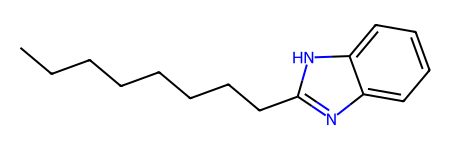

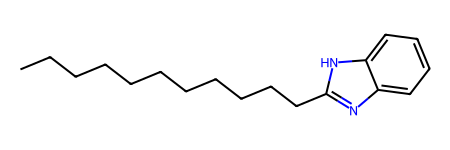

1.0


In [35]:
# visualize smiles
m1 = Chem.MolFromSmiles('CCCCCCCCc1nc2ccccc2[nH]1')
m2 = Chem.MolFromSmiles('CCCCCCCCCCCc1nc2ccccc2[nH]1')

fp1 = Chem.RDKFingerprint(m1)
fp2 = Chem.RDKFingerprint(m2)

sim = DataStructs.FingerprintSimilarity(fp1, fp2)

display(m1, m2)
print(sim)

In [34]:
Chem.MolToSmiles(m1), Chem.MolToSmiles(m2)

('CC(C)=CCC/C(C)=C/C(=O)O', 'CC(C)=CCCC(C)=CC(=O)O')

# Check data leaks

In [19]:
df_train = pd.read_json("data/datasets/NIST/NIST_split_filip/train.jsonl", lines=True, orient="records")
df_valid = pd.read_json("data/datasets/NIST/NIST_split_filip/valid.jsonl", lines=True, orient="records")
df_test = pd.read_json("data/datasets/NIST/NIST_split_filip/test.jsonl", lines=True, orient="records")

In [22]:
# check data leaks between train test and valid
smi_leaks_train_valid = set(df_train.smiles).intersection(set(df_valid.smiles))
smi_leaks_train_test = set(df_train.smiles).intersection(set(df_test.smiles))
smi_leaks_valid_test = set(df_valid.smiles).intersection(set(df_test.smiles))

print("Number of smiles leaks between train and valid:", len(smi_leaks_train_valid))
print("Number of smiles leaks between train and test:", len(smi_leaks_train_test))
print("Number of smiles leaks between valid and test:", len(smi_leaks_valid_test))

Number of smiles leaks between train and valid: 24
Number of smiles leaks between train and test: 26
Number of smiles leaks between valid and test: 2


In [23]:
# check actual number of smiles leaks
df_train_valid_leaks = df_train[df_train.smiles.isin(smi_leaks_train_valid)]
df_valid_train_leaks = df_valid[df_valid.smiles.isin(smi_leaks_train_valid)]
df_train_test_leaks = df_train[df_train.smiles.isin(smi_leaks_train_test)]
df_test_train_leaks = df_test[df_test.smiles.isin(smi_leaks_train_test)]
df_valid_test_leaks = df_valid[df_valid.smiles.isin(smi_leaks_valid_test)]
df_test_valid_leaks = df_test[df_test.smiles.isin(smi_leaks_valid_test)]

print("Number of smiles leaks between train and valid - in TRAIN SET:", len(df_train_valid_leaks))
print("Number of smiles leaks between train and valid - in VALID SET:", len(df_valid_train_leaks))
print("Number of smiles leaks between train and test - in TRAIN SET:", len(df_train_test_leaks))
print("Number of smiles leaks between train and test - in TEST SET:", len(df_test_train_leaks))
print("Number of smiles leaks between valid and test - in VALID SET:", len(df_valid_test_leaks))
print("Number of smiles leaks between valid and test - in TEST SET:", len(df_test_valid_leaks))

Number of smiles leaks between train and valid - in TRAIN SET: 45
Number of smiles leaks between train and valid - in VALID SET: 36
Number of smiles leaks between train and test - in TRAIN SET: 44
Number of smiles leaks between train and test - in TEST SET: 61
Number of smiles leaks between valid and test - in VALID SET: 3
Number of smiles leaks between valid and test - in TEST SET: 3


In [5]:
import numpy as np
a = np.array([1,2,3, 1])
sum(a == 1)

2

## Visualize fails of fp similarity on evaluation

,pred,label,pred_mol,label_mol
0,CCCCCCCCCCCC(C)OC(=O)c1cccs1,CCCCCCCCCCCCCC(C)OC(=O)c1cccs1,,
1,CC(C)CCCOC(=O)c1ccccc1C(=O)OCCCC(C)C,CCCOC(=O)c1ccccc1C(=O)OCCCC(C)C,,
2,CC#CC(CC)OC(=O)C=CC(=O)OC(C)C,CC#CC(CC)OC(=O)C=CC(=O)OCCC,,
3,CCCCCCCCCCCCCCCCCCCOC(=O)C=CC(=O)OCC1CCCO1,CCCCCCCCCCCCCCCCCOC(=O)C=CC(=O)OCC1CCCO1,,
4,CCCCCCCCCCCCCc1nc2ccccc2[nH]1,CCCCCCCCCCCc1nc2ccccc2[nH]1,,
5,CCCCCCCCCCCCCCCCCCCCOC(=O)CCCNC(=O)OCC(C)C,CCCCCCCCCCCCCCCCCOC(=O)CCCNC(=O)OCC(C)C,,

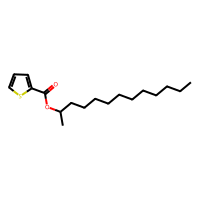
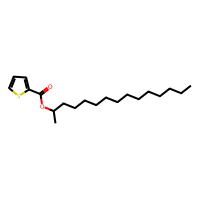
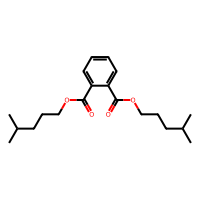
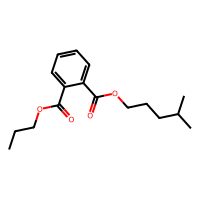
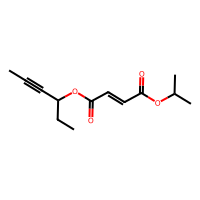
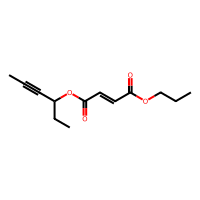
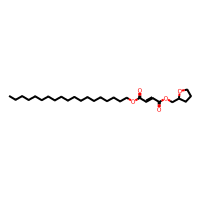
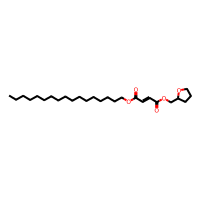
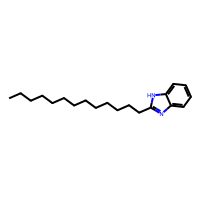
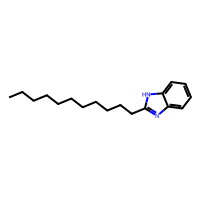
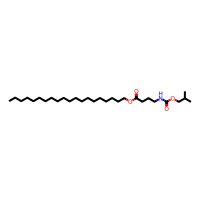
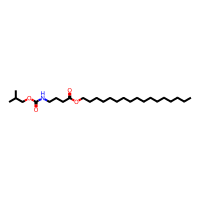

In [18]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames(images=True)

fails_path = "predictions/fresh-blaze-258_4_8M_rassp1_neims1_224kPretrain/NIST_denovo/1697801918_valid_0:50_beam10/fp_simil_fails.csv"
fails = pd.read_csv(fails_path)
fails["pred_mol"] = fails.pred.apply(Chem.MolFromSmiles)
fails["label_mol"] = fails.label.apply(Chem.MolFromSmiles)
fails["same"] = fails.apply(lambda x: x.pred == Chem.MolToSmiles(x.label_mol), axis=1)
fails

In [10]:
fails.columns

Index(['pred', ' label', 'pred_mol'], dtype='object')

In [19]:
fails.pred == fails.label

0    False
1    False
2    False
3    False
4    False
5    False
dtype: bool

# NIST non-canon check
Check num of non-canon smiles in preprocessed NIST database

In [8]:
df_train = pd.read_json("data/datasets/NIST/NIST_split_filip/train.jsonl", lines=True)
df_test = pd.read_json("data/datasets/NIST/NIST_split_filip/test.jsonl", lines=True)
df_valid = pd.read_json("data/datasets/NIST/NIST_split_filip/valid.jsonl", lines=True)

In [15]:
from rdkit import Chem
def compute_non_canoniacal(dataset):
    counter = 0
    for smiles in tqdm(dataset):
        mol = Chem.MolFromSmiles(smiles)
        if mol and Chem.MolToSmiles(mol) != smiles:
            counter += 1
    print(f"Number of spectra with a valid but non-canonical smiles: {counter}")

compute_non_canoniacal(df_train.smiles)
compute_non_canoniacal(df_valid.smiles)
compute_non_canoniacal(df_test.smiles)

  0%|          | 0/213406 [00:00<?, ?it/s]

 73%|███████▎  | 155924/213406 [00:24<00:09, 6306.15it/s][16:20:06] WARNING: not removing hydrogen atom without neighbors
[16:20:06] WARNING: not removing hydrogen atom without neighbors
 86%|████████▌ | 182912/213406 [00:28<00:04, 6427.42it/s][16:20:10] WARNING: not removing hydrogen atom without neighbors
[16:20:10] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 213406/213406 [00:33<00:00, 6352.31it/s]


Number of spectra with a valid but non-canonical smiles: 0


100%|██████████| 23870/23870 [00:03<00:00, 6392.93it/s]


Number of spectra with a valid but non-canonical smiles: 1


100%|██████████| 23672/23672 [00:03<00:00, 6341.12it/s]

Number of spectra with a valid but non-canonical smiles: 0


In [16]:
# test - how many spectra have chirality information
def compute_chirality(dataset):
    counter = 0
    for smiles in dataset:
        if "@" in smiles:
            counter += 1
    print(f"Number of spectra with chirality information: {counter}")

compute_chirality(df_train.smiles)
compute_chirality(df_valid.smiles)
compute_chirality(df_test.smiles)

Number of spectra with chirality information: 235
Number of spectra with chirality information: 34
Number of spectra with chirality information: 34


# Model with mf3000 debug

In [8]:
# imports
from tokenizers import Tokenizer
from train_bart import build_tokenizer

[2023-11-27 11:11:12,047] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [12]:
# load tokenizer
tokenizer = build_tokenizer("tokenizer/bbpe_tokenizer/bart_bbpe_tokenizer_1M_mf3000.model")
model_args = {"seq_len": 200,
  "encoder_layers": 12,
  "encoder_ffn_dim": 4096,
  "encoder_attention_heads": 16,
  "decoder_layers": 12,
  "decoder_ffn_dim": 4096,
  "decoder_attention_heads": 16}

In [15]:
# load model
config = BartSpektroConfig(vocab_size=len(tokenizer.get_vocab()),
                             max_position_embeddings=model_args["seq_len"],
                             max_length=model_args["seq_len"],
                             min_len=0,
                             encoder_layers=model_args["encoder_layers"],
                             encoder_ffn_dim=model_args["encoder_ffn_dim"],
                             encoder_attention_heads=model_args["encoder_attention_heads"],
                             decoder_layers=model_args["decoder_layers"],
                             decoder_ffn_dim=model_args["decoder_ffn_dim"],
                             decoder_attention_heads=model_args["decoder_attention_heads"],
                             encoder_layerdrop=0.0,
                             decoder_layerdrop=0.0,
                             activation_function='gelu',
                             d_model=1024,
                             dropout=0.2,
                             attention_dropout=0.0,
                             activation_dropout=0.0,
                             init_std=0.02,
                             classifier_dropout=0.0,
                             scale_embedding=False,
                             use_cache=True,
                             pad_token_id=2,
                             bos_token_id=3,
                             eos_token_id=0,
                             is_encoder_decoder=True,
                             decoder_start_token_id=3,
                             forced_eos_token_id=0,
                             max_log_id=9)

model = BartSpektroForConditionalGeneration(config)

In [10]:
list(filter(lambda x: x.startswith("<"), list(tokenizer.vocab.keys())))

['<ukn>',
 '<pad>',
 '<nist>',
 '<rassp>',
 '<neims>',
 '<source2>',
 '<trafo>',
 '<source3>',
 '<bos>',
 '<',
 '<source1>',
 '<eos>']

In [20]:
from tokenizers import BaseTokenizer
tok = tokenizers.BaseTokenizer(vocab={"Dobry":3, "<unk>":0}, unk_token="<unk>")
tok.decode("Dobry den, jak se dneska asi mate?")

ImportError: cannot import name 'BaseTokenizer' from 'tokenizers' (/home/xhajek9/miniconda3/envs/BARTtrain/lib/python3.8/site-packages/tokenizers/__init__.py)

In [3]:
# check lens of arrays in rassp dataset
row = {"input_ids":[29,30,38,39,40,41,42,43,44,45,46,47,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,77,78,79,80,81,82,83,84,85,86,87,88,91,92,93,94,95,96,97,98,99,100,101,102,105,106,107,108,109,110,111,112,113,114,115,116,120,121,122,123,124,125,126,127,128,129,130,136,137,138,139,140,141,142,143,144,150,151,152,153,154,155,156,157,158,166,167,168,169,170,181,182,183,184,195,196,197,209,210,211,223,224,225,226,238,239,240,241,242,268,269,270,271,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2],"position_ids":[0,3,0,6,3,8,7,9,7,5,0,0,1,2,5,5,7,6,3,8,3,1,0,0,0,3,3,4,5,5,6,4,6,2,1,0,2,0,2,3,5,5,3,6,5,5,0,0,0,0,2,3,4,5,3,6,4,4,0,0,0,0,1,2,2,3,3,6,3,4,0,0,0,0,1,0,1,6,5,3,1,0,0,0,0,1,6,5,3,5,1,0,0,0,0,6,4,9,5,4,0,0,3,2,1,0,2,1,2,0,0,0,0,0,0,0,0,0,3,0,0,8,4,2,0,0,3,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],"attention_mask":[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"smiles":"CCCC(CC)(CN)CN(C)C(C)c1cscn1","labels":[1235,224,296,11,261,289,263,12,263,11,38,12,38,11,38,12,70,20,443,20,0,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100],"decoder_attention_mask":[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]}
sel_row = {"input_ids": [18, 27, 28, 29, 30, 32, 39, 41, 42, 43, 44, 45, 53, 54, 55, 56, 57, 59, 61, 67, 68, 69, 70, 73, 74, 75, 77, 79, 80, 81, 82, 83, 84, 94, 95, 96, 108, 109, 110, 111, 122, 123, 124, 125, 128, 129, 136, 138, 139, 140, 167, 196, 197, 198, 206, 207, 210, 211, 222, 224, 225, 226, 235, 236, 240, 249, 268, 269, 296, 299, 300, 301, 305, 307, 311, 312, 313, 379, 396, 407, 416, 417, 421, 422, 436, 437, 438, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], "position_ids": [2, 1, 6, 4, 1, 2, 2, 6, 5, 3, 3, 3, 2, 1, 7, 5, 1, 2, 1, 3, 2, 3, 3, 7, 4, 3, 2, 1, 2, 2, 3, 5, 1, 1, 3, 3, 3, 2, 5, 4, 1, 1, 3, 3, 1, 1, 1, 9, 6, 1, 1, 1, 1, 1, 3, 1, 2, 2, 1, 4, 3, 3, 1, 1, 1, 1, 1, 1, 2, 6, 4, 1, 1, 2, 5, 4, 1, 1, 1, 2, 3, 3, 4, 2, 7, 5, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], "attention_mask": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "smiles": "[C][C][C][C][N][C][C][C][Ring1][=Branch1][C][C][Ring1][=Branch1][C][Branch1][#Branch2][O][Si][Branch1][C][C][Branch1][C][C][C][C][=C][C][=N][C][=C][C][Branch1][=Branch2][C][Branch1][C][F][Branch1][C][F][F][=C][C][=C][Ring1][=C][Ring1][#Branch2]", "labels": [78, 57, 57, 57, 57, 64, 57, 57, 57, 71, 26, 57, 57, 71, 26, 57, 52, 7, 67, 1, 52, 57, 57, 52, 57, 57, 57, 57, 31, 57, 35, 57, 31, 57, 52, 27, 57, 52, 57, 59, 52, 57, 59, 59, 31, 57, 31, 71, 31, 71, 7, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100], "decoder_attention_mask": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "mz": [18.0, 27.0, 28.0, 29.0, 30.0, 32.0, 39.0, 41.0, 42.0, 43.0, 44.0, 45.0, 53.0, 54.0, 55.0, 56.0, 57.0, 59.0, 61.0, 67.0, 68.0, 69.0, 70.0, 73.0, 74.0, 75.0, 77.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 94.0, 95.0, 96.0, 108.0, 109.0, 110.0, 111.0, 122.0, 123.0, 124.0, 125.0, 128.0, 129.0, 136.0, 138.0, 139.0, 140.0, 167.0, 196.0, 197.0, 198.0, 206.0, 207.0, 210.0, 211.0, 222.0, 224.0, 225.0, 226.0, 235.0, 236.0, 240.0, 249.0, 268.0, 269.0, 296.0, 299.0, 300.0, 301.0, 305.0, 307.0, 311.0, 312.0, 313.0, 379.0, 396.0, 407.0, 416.0, 417.0, 421.0, 422.0, 436.0, 437.0, 438.0], "intensity": [23.98, 13.99, 120.89, 51.95, 13.99, 17.98, 18.98, 134.88, 93.92, 31.97, 24.98, 39.96, 18.98, 12.99, 250.77, 83.92, 12.99, 18.98, 10.99, 30.97, 20.98, 40.96, 31.97, 331.7, 43.96, 38.96, 18.98, 11.99, 14.99, 15.99, 36.97, 72.93, 10.99, 12.99, 25.98, 24.98, 39.96, 14.99, 107.9, 47.96, 11.99, 11.99, 32.97, 26.98, 12.99, 9.99, 12.99, 999.0, 129.88, 10.99, 13.99, 9.99, 10.99, 10.99, 29.97, 9.99, 15.99, 20.98, 10.99, 49.95, 28.97, 29.97, 10.99, 12.99, 10.99, 12.99, 13.99, 9.99, 18.98, 179.84, 47.96, 12.99, 11.99, 15.99, 103.91, 48.96, 9.99, 13.99, 11.99, 17.98, 24.98, 24.98, 58.95, 16.98, 239.78, 77.93, 20.98]}
print(len(row["input_ids"]), len(sel_row["input_ids"]))
print(len(row["position_ids"]), len(sel_row["position_ids"]))
print(len(row["attention_mask"]), len(sel_row["attention_mask"]))
print(len(row["decoder_attention_mask"]), len(sel_row["decoder_attention_mask"]))
print(len(row["labels"]), len(sel_row["labels"]))


200 200
200 200
200 200
200 200
200 200


## Debug pushing SELFIES data to the model

In [18]:
from data_utils import SpectroDataset, SpectroDataCollator, load_all_datapipes, build_single_datapipe
from bart_spektro.modeling_bart_spektro import BartSpektroForConditionalGeneration
from bart_spektro.configuration_bart_spektro import BartSpektroConfig
from bart_spektro.selfies_tokenizer import hardcode_build_selfies_tokenizer
from tokenizers import Tokenizer
from torch.utils.data import DataLoader
from icecream import ic

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
model_args = {"tokenizer_path": "selfies_tokenizer", # not a path just for the trainer to know it should use sefies tokenizer 
            "seq_len": 200,   # !!!!!!!
            "encoder_layers": 12, # 24
            "encoder_ffn_dim": 4096,
            "encoder_attention_heads": 16,
            "decoder_layers": 12, # 24
            "decoder_ffn_dim": 4096,
            "decoder_attention_heads": 16}

In [23]:
tokenizer = hardcode_build_selfies_tokenizer()
config = BartSpektroConfig(vocab_size=len(tokenizer.get_vocab()),
                            max_mz=499,
                            max_position_embeddings=model_args["seq_len"],
                            max_length=model_args["seq_len"],
                            tie_word_embeddings=False,
                            min_len=0,
                            encoder_layers=model_args["encoder_layers"],
                            encoder_ffn_dim=model_args["encoder_ffn_dim"],
                            encoder_attention_heads=model_args["encoder_attention_heads"],
                            decoder_layers=model_args["decoder_layers"],
                            decoder_ffn_dim=model_args["decoder_ffn_dim"],
                            decoder_attention_heads=model_args["decoder_attention_heads"],
                            encoder_layerdrop=0.0,
                            decoder_layerdrop=0.0,
                            activation_function='gelu',
                            d_model=1024,
                            dropout=0.2,
                            attention_dropout=0.0,
                            activation_dropout=0.0,
                            init_std=0.02,
                            classifier_dropout=0.0,
                            scale_embedding=False,
                            use_cache=True,
                            pad_token_id=2,
                            bos_token_id=3,
                            eos_token_id=0,
                            is_encoder_decoder=True,
                            decoder_start_token_id=3,
                            forced_eos_token_id=0,
                            max_log_id=9)

In [24]:
model = BartSpektroForConditionalGeneration(config)
model.to("cpu")
None

In [25]:
model.lm_head.weight.shape, model.config.vocab_size

(torch.Size([85, 1024]), 85)

In [26]:
data = build_single_datapipe("data/datasets/NIST/NIST_split_filip/sel_train.jsonl")
None

In [27]:
loader = DataLoader(data, batch_size=128, collate_fn=SpectroDataCollator())

In [36]:
for i, batch in enumerate(loader):
    # if i > 434:
    #   break
    # if i < 430:
    #   continue
    ic(i, batch["input_ids"].max(), batch["input_ids"].min())
    # ic(batch)
    assert batch["input_ids"].shape[1] == model_args["seq_len"], f"{batch['input_ids'].shape[1]} != {model_args['seq_len']}"
    assert batch["attention_mask"].shape[1] == model_args["seq_len"], f"{batch['attention_mask'].shape[1]} != {model_args['seq_len']}"
    assert batch["decoder_attention_mask"].shape[1] == model_args["seq_len"], f"{batch['decoder_attention_mask'].shape[1]} != {model_args['seq_len']}"
    assert batch["input_ids"].max() < 501, f"{batch['input_ids'].max()} >= {501} \n {batch['input_ids']}"
    assert batch["input_ids"].min() >= 0, f"{batch['input_ids'].min()} < 0"
    # model(input_ids=batch["input_ids"],
    #       attention_mask=batch["attention_mask"],
    #       decoder_attention_mask=batch["decoder_attention_mask"],
    #       labels=batch["labels"],
    #       position_ids=batch["position_ids"])
    

ic| i: 0
    batch["input_ids"].max(): tensor(469)
    batch["input_ids"].min(): tensor(2)
ic| i: 1
    batch["input_ids"].max(): tensor(472)
    batch["input_ids"].min(): tensor(2)
ic| i: 2
    batch["input_ids"].max(): tensor(495)
    batch["input_ids"].min(): tensor(1)
ic| i: 3
    batch["input_ids"].max(): tensor(455)
    batch["input_ids"].min(): tensor(2)


ic| i: 4
    batch["input_ids"].max(): tensor(436)
    batch["input_ids"].min(): tensor(2)
ic| i: 5
    batch["input_ids"].max(): tensor(494)
    batch["input_ids"].min(): tensor(2)
ic| i: 6
    batch["input_ids"].max(): tensor(467)
    batch["input_ids"].min(): tensor(2)
ic| i: 7
    batch["input_ids"].max(): tensor(475)
    batch["input_ids"].min(): tensor(2)
ic| i: 8
    batch["input_ids"].max(): tensor(461)
    batch["input_ids"].min(): tensor(2)
ic| i: 9
    batch["input_ids"].max(): tensor(474)
    batch["input_ids"].min(): tensor(2)
ic| i: 10
    batch["input_ids"].max(): tensor(496)
    batch["input_ids"].min(): tensor(2)
ic| i: 11
    batch["input_ids"].max(): tensor(489)
    batch["input_ids"].min(): tensor(2)
ic| i: 12
    batch["input_ids"].max(): tensor(470)
    batch["input_ids"].min(): tensor(2)
ic| i: 13
    batch["input_ids"].max(): tensor(406)
    batch["input_ids"].min(): tensor(2)
ic| i: 14
    batch["input_ids"].max(): tensor(496)
    batch["input_ids"].min(): tens

KeyboardInterrupt: 

In [13]:
for batch in loader:
    if (batch["labels"] > 84).any():
        print(batch["labels"])

## check if embeddings for first n tokens are common

In [139]:
model = BartSpektroForConditionalGeneration.from_pretrained("checkpoints/bart_2023-04-07-18_27_23_30Mneims/checkpoint-1680000/")


In [66]:
model.model.encoder.embed_tokens.weight.data[0:800] == model.model.decoder.embed_tokens.weight.data[0:800] 

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [138]:
hasattr(config, "mz_ins")

False

## create selfies data

In [1]:
import selfies as sf
import json
from tqdm.notebook import tqdm
from pathlib import Path
from bart_spektro.selfies_tokenizer import hardcode_build_selfies_tokenizer

def dummy_generator(from_n_onwards=0):
    i = from_n_onwards
    while True:
        yield i
        i += 1

sel_tokenizer = hardcode_build_selfies_tokenizer()

# allowing 3 bonded Iodine atoms
default_constraints = sf.get_semantic_constraints()
default_constraints["I"] = 5
default_constraints["Ti"] = 13
default_constraints["P"] = 6
default_constraints["P-1"] = 6
sf.set_semantic_constraints(default_constraints)

def smiles_dataset_to_selfies_dataset(smiles_dataset_path, selfies_dataset_save_path, sel_tokenizer, source_id, seq_len=200):

    with open(smiles_dataset_path, "r") as f_smi, open(selfies_dataset_save_path, "w") as f_sel:
        for i in tqdm(dummy_generator()):
            smi_line = f_smi.readline()
            if not smi_line:
                break
            smi_row = json.loads(smi_line)
            smi_row["smiles"] = sf.encoder(smi_row["smiles"])
            tokenized_selfie = [source_id] + sel_tokenizer.encode(smi_row["smiles"]) + [sel_tokenizer.eos_token_id]
            assert len(tokenized_selfie) < seq_len, f"selfie: {tokenized_selfie}, len: {len(tokenized_selfie)} is too long!"
            smi_row["labels"] =  tokenized_selfie + [-100] * (seq_len - len(tokenized_selfie))
            assert len(smi_row["labels"]) == seq_len, f"selfie: {tokenized_selfie}, len: {len(tokenized_selfie)} labels len is different from seqlen!"
            smi_row["decoder_attention_mask"] = [1] * len(tokenized_selfie) + [0] * (seq_len - len(tokenized_selfie))
            sel_line = json.dumps(smi_row)
            f_sel.write(sel_line + "\n")

for datatype in ["train", "valid", "test"]:
    smiles_dataset_to_selfies_dataset(f"data/datasets/NIST/NIST_split_filip/{datatype}.jsonl", 
                                    f"data/datasets/NIST/NIST_split_filip/sel_{datatype}.jsonl", 
                                    sel_tokenizer, 
                                    sel_tokenizer.encode("[nist]")[0])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# Check peak range in NIST, NEIMS, RASSP
no, tak 
- NIST je indexovanej od 0
- NEIMS od 1
- a RASSP taky od 0

...


In [8]:
# load three dfs: valid, test and train set of NIST
df_train = pd.read_json("data/datasets/NIST/NIST_split_filip/train.jsonl", lines=True)
df_valid = pd.read_json("data/datasets/NIST/NIST_split_filip/valid.jsonl", lines=True)
df_test = pd.read_json("data/datasets/NIST/NIST_split_filip/test.jsonl", lines=True)

In [18]:
# load three dfs: valid, test and train set of NEIMS
df_train_neims = pd.read_json("data/datasets/30M_rassp/neims_gen/30M_rassp_train.jsonl", lines=True)
df_valid_neims = pd.read_json("data/datasets/30M_rassp/neims_gen/30M_rassp_valid.jsonl", lines=True)
df_test_neims = pd.read_json("data/datasets/30M_rassp/neims_gen/30M_rassp_test.jsonl", lines=True)


In [19]:
# load three dfs: valid, test and train set of RASSP
df_test_rassp = pd.read_json("data/datasets/30M_rassp/rassp_gen/test.jsonl", lines=True)
df_valid_rassp = pd.read_json("data/datasets/30M_rassp/rassp_gen/valid.jsonl", lines=True)
df_train_rassp = pd.read_json("data/datasets/30M_rassp/rassp_gen/train.jsonl", lines=True)




In [24]:
# check min/max for NIST
n = 0
print(sum(df_train.mz.apply(lambda x: n in x)))
print(sum(df_valid.mz.apply(lambda x: n in x)))
print(sum(df_test.mz.apply(lambda x: n in x)))

0
0
0


In [25]:
# do the same for NEIMS
n = 0
print(sum(df_train_neims.input_ids.apply(lambda x: n in x)))
print(sum(df_valid_neims.input_ids.apply(lambda x: n in x)))
print(sum(df_test_neims.input_ids.apply(lambda x: n in x)))



5415
296
322


In [26]:
# check min/max for RASSP
n = 0
print(sum(df_train_rassp.input_ids.apply(lambda x: n in x)))
print(sum(df_valid_rassp.input_ids.apply(lambda x: n in x)))
print(sum(df_test_rassp.input_ids.apply(lambda x: n in x)))


0
0
0
